## Analyzing Yogurt Data

Let's plot unit sales and unit prices over the entire period that we have data for.

In [1]:
import pandas as pd
df = pd.read_excel('DAA_yogurt_data.xlsx')
df.columns = [i.lower() for i in df.columns]
df.set_index('week',inplace=True)

In [2]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
df['yoplait units'].plot(ax=ax,figsize=(12,12))
ax.set_title('Unit Sales Over Time',size=13)
ax.set_xlabel('Week')
ax.set_ylabel('Sales')
plt.show()

<Figure size 1200x1200 with 1 Axes>

Notice that sales have generally increased over time, but that there are regular peaks and spikes, likely due to seasonality. We can confirm this by aggregating unit sales by month.

In [3]:
seasonality_check = df.groupby('month',as_index=False)['yoplait units'].mean()#.min()
seasonality_check['yoplait units']=seasonality_check['yoplait units']/1000000
seasonality_check

,month,yoplait units
0,Apr,1.994381
1,Aug,1.847313
2,Dec,1.433347
3,Feb,2.049579
4,Jan,2.121881
5,Jul,1.782642
6,Jun,1.909174
7,Mar,2.039577
8,May,1.997993
9,Nov,1.621332


When scaled, we can see that sales are highest in are in January, February, and March.

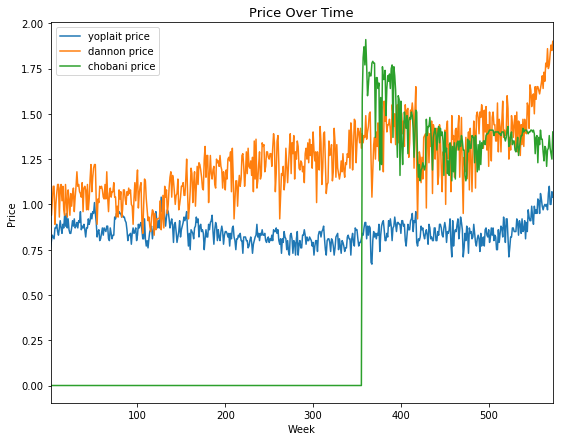

In [4]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
df[['yoplait price','dannon price','chobani price']].plot(ax=ax,figsize=(9,7))
ax.set_title('Price Over Time',size=13)
ax.set_xlabel('Week')
ax.set_ylabel('Price')
plt.show()

Chobani entered the market at a much higher price point than yoplait and dannon's, but has been trending down in price ever since it entered the market. dannon prices have increased over time, while yoplait's prices have been relatively stable over time.

Let's also analyze yoplait's unit sales against yoplait's price. We would expect a negative correlation (as we learned in class, the demand curve is downward-sloping).

In [5]:
df[['yoplait units','yoplait price']].corr()

,yoplait units,yoplait price
yoplait units,1.000000,-0.634392
yoplait price,-0.634392,1.000000


As expected, there's an inverse relationship between their price and units sold, with a correlation of -0.63.

Let's also look at the correlation matrix to observe the parity between units sold and prices from dannon's and chobani.

In [6]:
df.corr()

,yoplait units,yoplait price,dannon price,chobani price
yoplait units,1.000000,-0.634392,0.356164,0.482982
yoplait price,-0.634392,1.000000,0.133930,0.153306
dannon price,0.356164,0.133930,1.000000,0.654769
chobani price,0.482982,0.153306,0.654769,1.000000


There is actually a positive correlation between dannon and chobani price increases and yoplait units sold.

Let's perform regression analysis using the entire data and estimate demand for Yoplait products.

Three prices are already included in the dataframe. Insert time trend.

In [7]:
import numpy as np
df['time trend']=np.log(df.index)
df.head(3)

,month,yoplait units,yoplait price,dannon price,chobani price,time trend
week,,,,,,
1,Jan,1431790,0.76,1.04,0.0,0.000000
2,Jan,1549503,0.80,0.94,0.0,0.693147
3,Jan,1448646,0.83,1.02,0.0,1.098612


Let's create monthly dummy variables.

In [8]:
mon_dummies=pd.get_dummies(df['month'],prefix='mon')
df=pd.concat([df,mon_dummies],axis=1)

In [9]:
df.columns

Index(['month', 'yoplait units', 'yoplait price', 'dannon price',
       'chobani price', 'time trend', 'mon_Apr', 'mon_Aug', 'mon_Dec',
       'mon_Feb', 'mon_Jan', 'mon_Jul', 'mon_Jun', 'mon_Mar', 'mon_May',
       'mon_Nov', 'mon_Oct', 'mon_Sep'],
      dtype='object')

Convention is to drop the variable with the most data-points. They are effectively all the same, so let's drop Jan.

In [10]:
df.drop('mon_Jan',axis=1,inplace=True)

Let's confirm that the dataframe doesn't include January as a dummy variable.

In [11]:
df.columns

Index(['month', 'yoplait units', 'yoplait price', 'dannon price',
       'chobani price', 'time trend', 'mon_Apr', 'mon_Aug', 'mon_Dec',
       'mon_Feb', 'mon_Jul', 'mon_Jun', 'mon_Mar', 'mon_May', 'mon_Nov',
       'mon_Oct', 'mon_Sep'],
      dtype='object')

Perform regression.

We need to remove "_" from categorical variables for python to run regression.

In [12]:
df.columns=[i.replace("_","") for i in df.columns]
df.columns=[i.replace(" ","") for i in df.columns]

In [13]:
df.columns

Index(['month', 'yoplaitunits', 'yoplaitprice', 'dannonprice', 'chobaniprice',
       'timetrend', 'monApr', 'monAug', 'monDec', 'monFeb', 'monJul', 'monJun',
       'monMar', 'monMay', 'monNov', 'monOct', 'monSep'],
      dtype='object')

In [14]:
independent_variables=list(df.columns)
independent_variables.remove('month')
independent_variables.remove('yoplaitunits')
independent_variables

['yoplaitprice',
 'dannonprice',
 'chobaniprice',
 'timetrend',
 'monApr',
 'monAug',
 'monDec',
 'monFeb',
 'monJul',
 'monJun',
 'monMar',
 'monMay',
 'monNov',
 'monOct',
 'monSep']

In [15]:
from statsmodels.formula.api import ols
dependent_variable = 'yoplaitunits'
predictors = '+'.join(independent_variables)
formula = dependent_variable + '~' + predictors
model = ols(formula = formula, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           yoplaitunits   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     262.0
Date:                Mon, 29 Jul 2019   Prob (F-statistic):          8.50e-241
Time:                        21:46:42   Log-Likelihood:                -7698.2
No. Observations:                 573   AIC:                         1.543e+04
Df Residuals:                     557   BIC:                         1.550e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.543e+06   1.28e+05     35.443   

In [16]:
model.rsquared

0.8758694188053224

R-squared is ~.88.

In [17]:
model.params

Intercept       4.543197e+06
yoplaitprice   -4.306898e+06
dannonprice     8.058438e+04
chobaniprice    2.558855e+05
timetrend       1.573041e+05
monApr          9.273806e+03
monAug         -1.023708e+04
monDec         -4.167889e+05
monFeb          4.094724e+04
monJul         -7.340230e+04
monJun         -5.279838e+04
monMar          5.953216e+04
monMay          3.288820e+03
monNov         -2.777466e+05
monOct         -6.732218e+04
monSep          3.676221e+04
dtype: float64

In [18]:
model.pvalues

Intercept       7.090240e-145
yoplaitprice    3.627100e-138
dannonprice      1.379737e-01
chobaniprice     1.479942e-52
timetrend        2.793180e-43
monApr           7.920793e-01
monAug           7.792003e-01
monDec           4.885342e-26
monFeb           2.491712e-01
monJul           4.266280e-02
monJun           1.380393e-01
monMar           8.459666e-02
monMay           9.245856e-01
monNov           2.151640e-13
monOct           5.664888e-02
monSep           3.117324e-01
dtype: float64

Let's compute the predicted unit sales of Yoplait for all 573 weeks, and plot both observed and predicted unit sales with 95% prediction interval over time.

In [19]:
df['predictedsales']=1
df['predictedsales']=(model.params['Intercept']*1+
                      model.params['yoplaitprice']*df['yoplaitprice']+
                      model.params['dannonprice']*df['dannonprice']+
                      model.params['chobaniprice']*df['chobaniprice']+
                      model.params['timetrend']*df['timetrend']+
                      model.params['monFeb']*df['monFeb']+
                      model.params['monMar']*df['monMar']+
                      model.params['monApr']*df['monApr']+
                      model.params['monMay']*df['monMay']+
                      model.params['monJun']*df['monJun']+
                      model.params['monJul']*df['monJul']+
                      model.params['monAug']*df['monAug']+
                      model.params['monSep']*df['monSep']+
                      model.params['monOct']*df['monOct']+
                      model.params['monNov']*df['monNov']+
                      model.params['monDec']*df['monDec'])

In [20]:
df['predictedsales'].mean()

1896826.4729493826

This matches the value I get in excel.

Now let's create a 95% confidence interval. We'll use +- 2 * standard error for our bound. We'll also compute MAPE.

In [21]:
standarderror=167734.909630095
df['lowbound95']=df['predictedsales']-1.96*standarderror
df['highbound95']=df['predictedsales']+1.96*standarderror
df['mape']=(abs(df['predictedsales']-df['yoplaitunits']))/(df['yoplaitunits'])

In [22]:
print('Average of Predicted Sales: ' + str(df['predictedsales'].mean()))
print('Average of 95% CI Lower Bound: ' + str(df['lowbound95'].mean()))
print('Average of 95% CI Upper Bound: ' + str(df['highbound95'].mean()))
print('')
print('Average of MAPE Values: ' + str(df['mape'].mean()))

Average of Predicted Sales: 1896826.4729493826
Average of 95% CI Lower Bound: 1568066.050074397
Average of 95% CI Upper Bound: 2225586.89582437

Average of MAPE Values: 0.07259078870634557


Now let's plot everything.

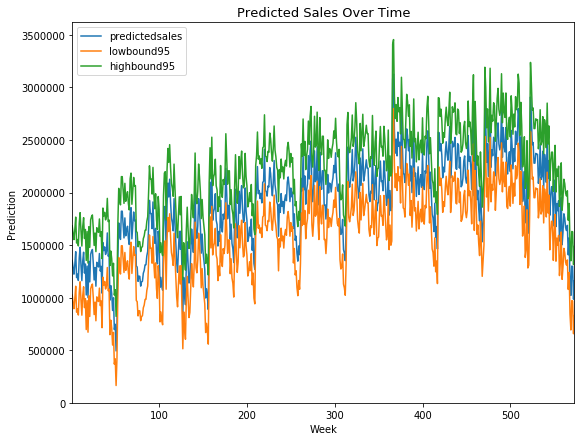

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
df[['predictedsales','lowbound95','highbound95']].plot(ax=ax,figsize=(9,7))
ax.set_title('Predicted Sales Over Time',size=13)
ax.set_xlabel('Week')
ax.set_ylabel('Prediction')
plt.legend()
plt.show()

Let's compute weekly price elasticities of Yoplait demand (own- and two cross-price elasticities).

In [24]:
df['ownelasticity']=model.params['yoplaitprice']*df['yoplaitprice']/df['predictedsales']
df['crossdannon']=model.params['dannonprice']*df['dannonprice']/df['predictedsales']
df['crosschobani']=model.params['chobaniprice']*df['chobaniprice']/df['predictedsales']

In [25]:
df_prechobani=df.loc[df.index<356]
df_postchobani=df.loc[df.index>=356]

In [26]:
a=df_prechobani['ownelasticity'].mean()
b=df_prechobani['crossdannon'].mean()
c=df_prechobani['crosschobani'].mean()
print('Pre-Chobani: Own Elasticity ', a)
print('Pre-Chobani: Cross Dannon ', b)
print('Pre-Chobani: Cross Chobani ', c)

Pre-Chobani: Own Elasticity  -2.2836216791501633
Pre-Chobani: Cross Dannon  0.05614998038497224
Pre-Chobani: Cross Chobani  0.0


In [27]:
d=df_postchobani['ownelasticity'].mean()
e=df_postchobani['crossdannon'].mean()
f=df_postchobani['crosschobani'].mean()
print('Post-Chobani: Own Elasticity ', d)
print('Post-Chobani: Cross Dannon ', e)
print('Post-Chobani: Cross Chobani ', f)

Post-Chobani: Own Elasticity  -1.7857630542663117
Post-Chobani: Cross Dannon  0.05453197144187264
Post-Chobani: Cross Chobani  0.16950989547366604


Now, in table form...

In [28]:
table_q4=pd.DataFrame({"Before Chobani Entrance": [a,b,c],
                       "After Chobani Entrance": [d,e,f]})
table_q4.index=['1%Δ in price YOPLAIT','1%Δ in price DANNON','1%Δ in price CHOBANI']
table_q4

,Before Chobani Entrance,After Chobani Entrance
1%Δ in price YOPLAIT,-2.283622,-1.785763
1%Δ in price DANNON,0.056150,0.054532
1%Δ in price CHOBANI,0.000000,0.169510


Yoplait demand increases as a result of increases in price by dannon and chobani. Yogurt purchasers are elastic and are willing to substitute one brand with the other.

In [29]:
df_prechobani.describe()['yoplaitunits']

count    3.550000e+02
mean     1.715546e+06
std      4.013492e+05
min      7.041570e+05
25%      1.409784e+06
50%      1.671889e+06
75%      2.020082e+06
max      2.812702e+06
Name: yoplaitunits, dtype: float64

In [30]:
df_postchobani.describe()['yoplaitunits']

count    2.180000e+02
mean     2.192032e+06
std      4.215443e+05
min      1.076198e+06
25%      1.943486e+06
50%      2.202517e+06
75%      2.471222e+06
max      3.374058e+06
Name: yoplaitunits, dtype: float64

Demand for yoplait increased (on average, as seen above) after the entrance of chobani. It is likely that chobani's higher price point made yoplait look like a more attractive alternative. 